## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
#Importing libraries

nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\padma\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [3]:
import nltk
nltk.download('tagsets')
nltk.help.upenn_tagset()

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\padma\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas 

In [4]:
import nltk
nltk.download('universal_tagset')  

 

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\padma\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [5]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

### Build the vanilla Viterbi based POS tagger

In [6]:
# first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [7]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:10])


3718
196
[[('*-2', 'X'), ('Knowing', 'VERB'), ('a', 'DET'), ('tasty', 'ADJ'), ('--', '.'), ('and', 'CONJ'), ('free', 'ADJ'), ('--', '.'), ('meal', 'NOUN'), ('when', 'ADV'), ('they', 'PRON'), ('eat', 'VERB'), ('one', 'NUM'), ('*T*-1', 'X'), (',', '.'), ('the', 'DET'), ('executives', 'NOUN'), ('gave', 'VERB'), ('the', 'DET'), ('chefs', 'NOUN'), ('a', 'DET'), ('standing', 'ADJ'), ('ovation', 'NOUN'), ('.', '.')], [('@', 'ADP')], [('``', '.'), ('*', 'X'), ('Remember', 'VERB'), ('Pinocchio', 'NOUN'), ('?', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('a', 'DET'), ('female', 'ADJ'), ('voice', 'NOUN'), ('.', '.')], [('Typically', 'ADV'), (',', '.'), ('money-fund', 'NOUN'), ('yields', 'NOUN'), ('beat', 'VERB'), ('comparable', 'ADJ'), ('short-term', 'ADJ'), ('investments', 'NOUN'), ('because', 'ADP'), ('portfolio', 'NOUN'), ('managers', 'NOUN'), ('can', 'VERB'), ('vary', 'VERB'), ('maturities', 'NOUN'), ('and', 'CONJ'), ('go', 'VERB'), ('after', 'ADP'), ('the', 'DET'), ('highest', 'ADJ

In [8]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95507

In [9]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['*-2', 'Knowing', 'a', 'tasty', '--', 'and', 'free', '--', 'meal', 'when']

In [10]:
# vocabulary
V = set(tokens)
print(len(V))

12073


In [11]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [12]:
print(T)

{'NUM', 'NOUN', 'DET', 'ADV', 'ADP', 'PRT', 'VERB', 'ADJ', 'X', '.', 'CONJ', 'PRON'}


In [13]:
len(train_tagged_words)

95507

### Emission Probabilities

In [14]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [15]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [16]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NUM'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'VERB'))
print(word_given_tag('will', 'PRT'))
print(word_given_tag('will', 'DET'))
print(word_given_tag('will', 'X'))
print(word_given_tag('will', 'CONJ'))
print(word_given_tag('will', 'PRON'))
print(word_given_tag('will', 'ADJ'))
print(word_given_tag('will', 'ADV'))
print(word_given_tag('will', 'ADP'))  
print(word_given_tag('will', 'X'))        
print(word_given_tag('will', '.'))  
print(word_given_tag('will', 'NUM'))        
      
# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(25, 6047)
(0, 12873)
(0, 3343) 


 will
(262, 12873)
(0, 3055)
(0, 8279)
(0, 6295)
(0, 2157)
(0, 2623)
(0, 6047)
(0, 3012)
(0, 9324)
(0, 6295)
(0, 11110)
(0, 3343)

 book
(7, 27389)
(1, 12873)


## Analysis 

Most unknown words belong to Tag class "NOUN" - 27371 times Noun Tag class assigned.


The 3 most assigned tags are NOUN,VERB,ADP and least assigned tag is CONJ

In [17]:
### Transition Probabilities

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'NUM'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1(',', 'NOUN'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('ADP', 'VERB'))
print(t2_given_t1('PRT', 'VERB'))
print(t2_given_t1('NOUN', 'CONJ'))
print(t2_given_t1('NOUN', 'ADP'))
print(t2_given_t1('VERB', 'PRON'))
print(t2_given_t1('PRON', 'DET'))

(4223, 6047)
(5294, 8279)
(1168, 3343)
(1425, 12873)
(0, 27389)
(20, 2623)
(4018, 27389)
(1152, 12873)
(401, 12873)
(756, 2157)
(3021, 9324)
(1269, 2623)
(28, 8279)


##  Analysis of which Tag follows most of the times another Tag 

Tag Class 'NOUN' follows 'DET' 5299 times.
Tag Class 'VERB' follows 'NOUN' 4030 times.
Tag Class 'NOUN' follows 'ADJ' 4247 times

In [20]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('ADJ', '.'))
print(t2_given_t1('PRON', '.'))
print(t2_given_t1('NUM', '.'))
print(t2_given_t1('PRT', '.'))
print(t2_given_t1('X', '.'))
print(t2_given_t1('ADP', '.'))
print(t2_given_t1('ADV', '.'))
print(t2_given_t1('CONJ', '.'))


(1933, 11110)
(986, 11110)
(2461, 11110)
(499, 11110)
(731, 11110)
(888, 11110)
(26, 11110)
(301, 11110)
(1014, 11110)
(584, 11110)
(653, 11110)


## Analysis - sentence started most of the times with the given tags 

Most of the sentenses started with the tag set Noun - 2469 times 
followed by 'DET'-1943 times ,'ADP'-1008 times


In [21]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [22]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))


In [23]:
tags_df

,NUM,NOUN,DET,ADV,ADP,PRT,VERB,ADJ,X,.,CONJ,PRON
NUM,0.189052,0.349387,0.002991,0.002991,0.035896,0.026025,0.017649,0.032905,0.209991,0.116961,0.014657,0.001496
NOUN,0.009310,0.264449,0.013327,0.016941,0.176640,0.044251,0.146701,0.012195,0.029172,0.239877,0.042499,0.004637
DET,0.021983,0.639449,0.005556,0.012441,0.009301,0.000121,0.039377,0.203406,0.046262,0.018239,0.000483,0.003382
ADV,0.031873,0.031873,0.069057,0.081009,0.118194,0.014276,0.342629,0.129482,0.024236,0.135126,0.006640,0.015604
ADP,0.061562,0.324003,0.322716,0.013406,0.016946,0.001502,0.008151,0.105105,0.035178,0.040326,0.000858,0.070249
PRT,0.056628,0.246481,0.100164,0.009820,0.020622,0.001637,0.401309,0.085434,0.013421,0.044190,0.001637,0.018658
VERB,0.022838,0.110697,0.135788,0.082188,0.089490,0.031150,0.169036,0.064476,0.218597,0.034335,0.005438,0.035967
ADJ,0.020341,0.698363,0.004961,0.004961,0.076732,0.011080,0.012237,0.067141,0.020837,0.065487,0.017199,0.000661
X,0.002701,0.063066,0.053535,0.025735,0.144400,0.184114,0.205878,0.017315,0.073709,0.162669,0.010326,0.056553
.,0.079928,0.221512,0.173987,0.052565,0.091269,0.002340,0.088749,0.044914,0.027093,0.092979,0.058776,0.065797


In [24]:
tags_df.loc['.', :]

NUM     0.079928
NOUN    0.221512
DET     0.173987
ADV     0.052565
ADP     0.091269
PRT     0.002340
VERB    0.088749
ADJ     0.044914
X       0.027093
.       0.092979
CONJ    0.058776
PRON    0.065797
Name: ., dtype: float32

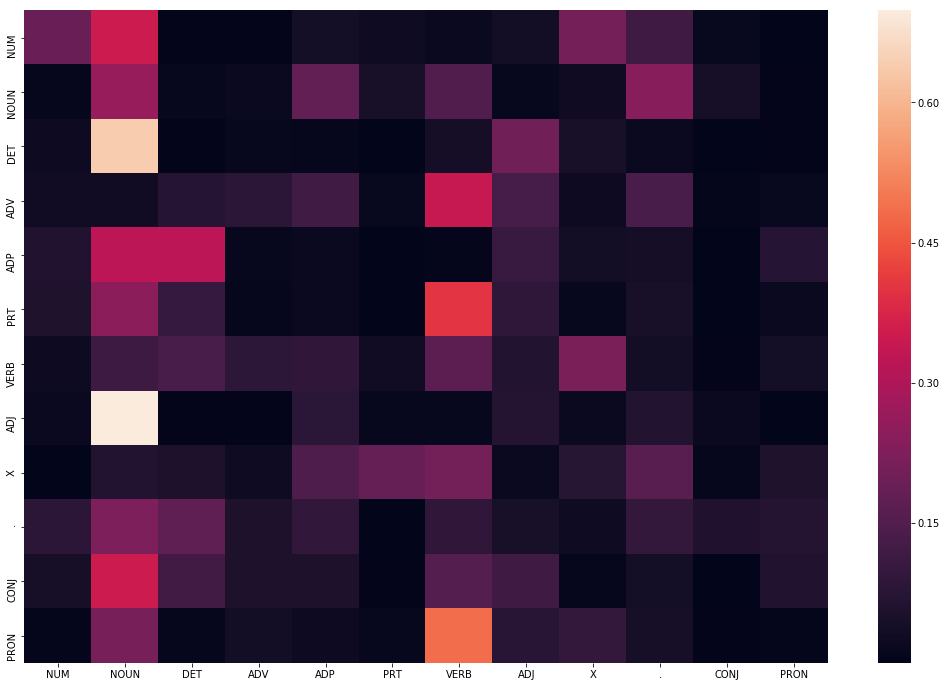

In [25]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


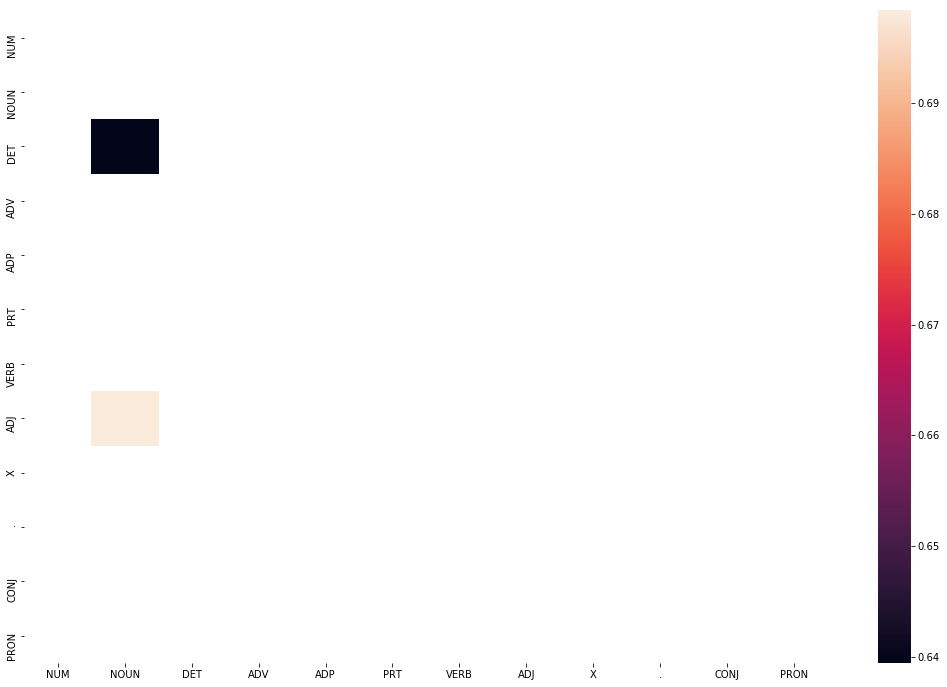

In [26]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [27]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/(word_given_tag(words[key], tag)[1])
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [28]:
## Evaluating on Test Set

# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
#rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
#test_run = [test_set[i] for i in rndom]
test_run=test_set
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run


[[('Garbage', 'NOUN'),
  ('editors', 'NOUN'),
  ('have', 'VERB'),
  ('dumped', 'VERB'),
  ('considerable', 'ADJ'),
  ('energy', 'NOUN'),
  ('into', 'ADP'),
  ('a', 'DET'),
  ('whirling', 'ADJ'),
  ('rampage', 'NOUN'),
  ('through', 'ADP'),
  ('supermarket', 'NOUN'),
  ('aisles', 'NOUN'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('bid', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('identify', 'VERB'),
  ('corporate', 'ADJ'),
  ('America', 'NOUN'),
  ("'s", 'PRT'),
  ('good', 'ADJ'),
  ('guys', 'NOUN'),
  ('and', 'CONJ'),
  ('bad', 'ADJ'),
  ('boys', 'NOUN'),
  ('.', '.')],
 [('Proper', 'ADJ'),
  ('English', 'ADJ'),
  ('bells', 'NOUN'),
  ('are', 'VERB'),
  ('started', 'VERB'),
  ('*-1', 'X'),
  ('off', 'PRT'),
  ('in', 'ADP'),
  ('``', '.'),
  ('rounds', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('highest-pitched', 'ADJ'),
  ('bell', 'NOUN'),
  ('to', 'PRT'),
  ('the', 'DET'),
  ('lowest', 'ADJ'),
  ('--', '.'),
  ('a', 'DET'),
  ('simple', 'ADJ'),
  ('descend

In [29]:
len(test_tagged_words)

5169

In [30]:
test_tagged_words

['Garbage',
 'editors',
 'have',
 'dumped',
 'considerable',
 'energy',
 'into',
 'a',
 'whirling',
 'rampage',
 'through',
 'supermarket',
 'aisles',
 'in',
 'a',
 'bid',
 '*',
 'to',
 'identify',
 'corporate',
 'America',
 "'s",
 'good',
 'guys',
 'and',
 'bad',
 'boys',
 '.',
 'Proper',
 'English',
 'bells',
 'are',
 'started',
 '*-1',
 'off',
 'in',
 '``',
 'rounds',
 ',',
 "''",
 'from',
 'the',
 'highest-pitched',
 'bell',
 'to',
 'the',
 'lowest',
 '--',
 'a',
 'simple',
 'descending',
 'scale',
 'using',
 ',',
 'in',
 'larger',
 'churches',
 ',',
 'as',
 'many',
 'as',
 '12',
 'bells',
 '.',
 'Programs',
 'like',
 'Section',
 '8',
 '-LRB-',
 'A',
 '-RRB-',
 'are',
 'a',
 'little',
 'like',
 '*',
 'leaving',
 'gold',
 'in',
 'the',
 'street',
 'and',
 'then',
 'expressing',
 'surprise',
 'when',
 'thieves',
 'walk',
 'by',
 '*-2',
 'to',
 'scoop',
 'it',
 'up',
 '*T*-1',
 '.',
 'If',
 'spreads',
 'available',
 'from',
 'index',
 'arbitrage',
 'are',
 'so',
 'enormous',
 ',',
 's

In [31]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


Time taken in seconds:  850.8772819042206


In [32]:

#print("Time taken in seconds: ", difference)
print(tagged_seq)


[('Garbage', 'NOUN'), ('editors', 'NOUN'), ('have', 'VERB'), ('dumped', 'VERB'), ('considerable', 'ADJ'), ('energy', 'NOUN'), ('into', 'ADP'), ('a', 'DET'), ('whirling', 'NUM'), ('rampage', 'NUM'), ('through', 'ADP'), ('supermarket', 'NUM'), ('aisles', 'NUM'), ('in', 'ADP'), ('a', 'DET'), ('bid', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('identify', 'VERB'), ('corporate', 'ADJ'), ('America', 'NOUN'), ("'s", 'PRT'), ('good', 'ADJ'), ('guys', 'NUM'), ('and', 'CONJ'), ('bad', 'ADJ'), ('boys', 'NOUN'), ('.', '.'), ('Proper', 'NUM'), ('English', 'NOUN'), ('bells', 'NOUN'), ('are', 'VERB'), ('started', 'VERB'), ('*-1', 'X'), ('off', 'PRT'), ('in', 'ADP'), ('``', '.'), ('rounds', 'NUM'), (',', '.'), ("''", '.'), ('from', 'ADP'), ('the', 'DET'), ('highest-pitched', 'NUM'), ('bell', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('lowest', 'ADJ'), ('--', '.'), ('a', 'DET'), ('simple', 'ADJ'), ('descending', 'NUM'), ('scale', 'NUM'), ('using', 'VERB'), (',', '.'), ('in', 'ADP'), ('larger', 'ADJ'), ('churche

In [33]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [34]:
accuracy = len(check)/len(tagged_seq)

In [35]:
accuracy

0.9082994776552524

In [36]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]



In [37]:
incorrect_tags =[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_words = [w[0] for in_wo in incorrect_tags for w in in_wo]
set(incorrect_words)

{"'s",
 '*-108',
 '*-128',
 '*-94',
 '*NOT*',
 '*T*-169',
 '*T*-200',
 '*T*-204',
 '*T*-211',
 '*T*-86',
 '69-point',
 '90-cent-an-hour',
 'A',
 'ASSETS',
 'Advocates',
 'Altogether',
 'American',
 'American-made',
 'Amin',
 'Antitrust',
 'Average',
 'Berson',
 'Bethlehem',
 'Borge',
 'Budget',
 'Cab',
 'Century',
 'Cheetham',
 'Child',
 'Civil',
 'Club',
 'Commodore',
 'Concerned',
 'Consider',
 'Crew',
 'Darrell',
 'Deborah',
 'Division',
 'Dodger',
 'Doerflinger',
 'EC',
 'Eakle',
 'Elders',
 'Employers',
 'English',
 'Express-Buick',
 'F-series',
 'FAMILY',
 'Filling',
 'Fishman',
 'Floyd',
 'Fuentes',
 'Glenham',
 'Gringo',
 'Herrington',
 'Homebrew',
 'Hospital',
 'Hot',
 'Hudnut',
 'Hutchinson',
 'I',
 'In',
 'Inland',
 'Iran\\/Contra',
 'Jalaalwalikraam',
 'Jobs',
 'Joni',
 'Knapp',
 'LYNCH',
 'Legislating',
 'Lezovich',
 'Little',
 'Long',
 'Longwood',
 'MERRILL',
 'Mayer',
 'Mexican',
 'Milwaukee',
 'Minn.',
 'Monitor',
 'Muscolina',
 'Najarian',
 'Nearby',
 'Nesconset',
 'Ne

In [38]:
incorrect_words = [w[0] for in_wo in incorrect_tagged_cases for w in in_wo]
set(incorrect_words)

{'%',
 '&',
 "'",
 "''",
 "'re",
 "'s",
 ("'s", 'PRT'),
 ("O'Neill", 'NUM'),
 ('*-108', 'NUM'),
 ('*-128', 'NUM'),
 ('*-94', 'NUM'),
 ('*NOT*', 'NUM'),
 ('*T*-169', 'NUM'),
 ('*T*-200', 'NUM'),
 ('*T*-204', 'NUM'),
 ('*T*-211', 'NUM'),
 ('*T*-86', 'NUM'),
 ('69-point', 'NUM'),
 ('90-cent-an-hour', 'NUM'),
 ('A', 'DET'),
 ('ASSETS', 'NUM'),
 ('Advocates', 'NUM'),
 ('Altogether', 'NUM'),
 ('American', 'ADJ'),
 ('American-made', 'NUM'),
 ('Amin', 'NUM'),
 ('Antitrust', 'NUM'),
 ('Average', 'NOUN'),
 ('Berson', 'NUM'),
 ('Bethlehem', 'NUM'),
 ('Borge', 'NUM'),
 ('Budget', 'NUM'),
 ('Cab', 'NUM'),
 ('Century', 'NUM'),
 ('Cheetham', 'NUM'),
 ('Child', 'NUM'),
 ('Civil', 'NUM'),
 ('Club', 'NUM'),
 ('Commodore', 'NUM'),
 ('Concerned', 'NUM'),
 ('Consider', 'NUM'),
 ('Crew', 'NUM'),
 ('Darrell', 'NUM'),
 ('Deborah', 'NUM'),
 ('Division', 'NUM'),
 ('Dodger', 'NUM'),
 ('Doerflinger', 'NUM'),
 ('EC', 'NUM'),
 ('Eakle', 'NUM'),
 ('Elders', 'NUM'),
 ('Employers', 'NUM'),
 ('English', 'NOUN'),
 ('Exp

In [39]:
## Testing
sentence_test = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [40]:
print(tagged_seq)
print(difference)

[('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
2.377054452896118


In [41]:
## Testing
sentence_test = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start


In [42]:
print(tagged_seq)
print(difference)

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.')]
1.4013259410858154


In [43]:
## Testing
sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter s firehose.'
words = word_tokenize(sentence_test)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start


In [44]:
print(tagged_seq)
print(difference)

[('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ('s', 'NUM'), ('firehose', 'NUM'), ('.', '.')]
2.3828511238098145


### Solve the problem of unknown words

###  Viterbi Heuristic - Modified function with Laplace smoothing


In [45]:

def Viterbi_modified_smoothing(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    V= len(list(set([pair[0] for pair in words])))
    print(V)  
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
           
            emission_p = word_given_tag(words[key], tag)[0]+1/(word_given_tag(words[key], tag)[1]+V)
                         
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [46]:
## Evaluating on Test Set

# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1345)

# choose random 20 sents
#rndom = [random.randint(1,len(test_set)) for x in range(30)]

# list of sents
#test_run1 = [test_set[i] for i in rndom]
test_run1=test_set
# list of tagged words
test_run_base1 = [tup for sent in test_run1 for tup in sent]

# list of untagged words
test_tagged_words1 = [tup[0] for sent in test_run1 for tup in sent]
test_run1


[[('Garbage', 'NOUN'),
  ('editors', 'NOUN'),
  ('have', 'VERB'),
  ('dumped', 'VERB'),
  ('considerable', 'ADJ'),
  ('energy', 'NOUN'),
  ('into', 'ADP'),
  ('a', 'DET'),
  ('whirling', 'ADJ'),
  ('rampage', 'NOUN'),
  ('through', 'ADP'),
  ('supermarket', 'NOUN'),
  ('aisles', 'NOUN'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('bid', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('identify', 'VERB'),
  ('corporate', 'ADJ'),
  ('America', 'NOUN'),
  ("'s", 'PRT'),
  ('good', 'ADJ'),
  ('guys', 'NOUN'),
  ('and', 'CONJ'),
  ('bad', 'ADJ'),
  ('boys', 'NOUN'),
  ('.', '.')],
 [('Proper', 'ADJ'),
  ('English', 'ADJ'),
  ('bells', 'NOUN'),
  ('are', 'VERB'),
  ('started', 'VERB'),
  ('*-1', 'X'),
  ('off', 'PRT'),
  ('in', 'ADP'),
  ('``', '.'),
  ('rounds', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('highest-pitched', 'ADJ'),
  ('bell', 'NOUN'),
  ('to', 'PRT'),
  ('the', 'DET'),
  ('lowest', 'ADJ'),
  ('--', '.'),
  ('a', 'DET'),
  ('simple', 'ADJ'),
  ('descend

In [47]:
len(test_tagged_words1)


5169

In [48]:

# tagging the test sentences
start1 = time.time()
tagged_seq1 = Viterbi_modified_smoothing(test_tagged_words1)
end1 = time.time()
difference = end1-start1
print("Time taken in seconds: ", difference)

68
Time taken in seconds:  713.2610037326813


In [49]:


print(tagged_seq1)

[('Garbage', 'NOUN'), ('editors', 'NOUN'), ('have', 'VERB'), ('dumped', 'VERB'), ('considerable', 'ADJ'), ('energy', 'NOUN'), ('into', 'ADP'), ('a', 'DET'), ('whirling', 'ADJ'), ('rampage', 'NOUN'), ('through', 'ADP'), ('supermarket', 'DET'), ('aisles', 'ADJ'), ('in', 'ADP'), ('a', 'DET'), ('bid', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('identify', 'VERB'), ('corporate', 'ADJ'), ('America', 'NOUN'), ("'s", 'PRT'), ('good', 'ADJ'), ('guys', 'NOUN'), ('and', 'CONJ'), ('bad', 'ADJ'), ('boys', 'NOUN'), ('.', '.'), ('Proper', 'CONJ'), ('English', 'NOUN'), ('bells', 'NOUN'), ('are', 'VERB'), ('started', 'VERB'), ('*-1', 'X'), ('off', 'PRT'), ('in', 'ADP'), ('``', '.'), ('rounds', 'CONJ'), (',', '.'), ("''", '.'), ('from', 'ADP'), ('the', 'DET'), ('highest-pitched', 'ADJ'), ('bell', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('lowest', 'ADJ'), ('--', '.'), ('a', 'DET'), ('simple', 'ADJ'), ('descending', 'NOUN'), ('scale', '.'), ('using', 'VERB'), (',', '.'), ('in', 'ADP'), ('larger', 'ADJ'), ('chur

In [50]:
# accuracy
check1 = [i for i, j in zip(tagged_seq1, test_run_base1) if i == j] 

accuracy1 = len(check1)/len(tagged_seq1)
accuracy1

0.9154575353066358

## Modifying  original Viterbi Alogorithm  2 - for unknown words

Rule-Based (Regular Expression) Tagger

Now let's build a rule-based, or regular expression based tagger. In NLTK, the RegexpTagger() can be provided with handwritten regular expression patterns, as shown below.

we specify regexes for Verbs, plural nouns , numbers and finally, if none of the above rules are applicable to a word, we tag the most frequent tag NOUN.

In [51]:
def Viterbi_modified_RuleBasedTagger(train_set,test_set):
  # specify patterns for tagging
  # example from the NLTK book

    patterns = [ (r'.*ing$', 'VERB'),              # VERB
             (r'.*ed$', 'VERB'),               # past tense
             (r'.*es$', 'VERB'),               # 3rd singular present
             (r'.*s$', 'NOUN'),                # plural nouns
             (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
             (r'.*', 'NOUN')             
           ]

# rule based tagger
    rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
    lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
    a=lexicon_tagger.evaluate(test_set)
    return a
    

In [66]:
accu=Viterbi_modified_RuleBasedTagger(train_set,test_set)
print (accu)

0.946798220158638


#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

## Tagging Accuracies 

1.Vanilla Viterbi alogorithm - 0.9082994776552524

2.Modified Viterbi alogorithm ( laplace smoothing)-0.9154575353066358

3.Rule based regular expression tagger -0.946798220158638

Modified Viterbi alogorithm with laplace smoothing has accuracy 0.915 comparitively 0.908.
Rule based regular expression accuracy is 0.946 which is more than the Vanilla Viterbi and Modified viterbi alogorithm


In [94]:
## Testing
sentence_test1 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words1 = word_tokenize(sentence_test1)
start = time.time()
tagged_seq1 = Viterbi(words1)
end = time.time()
difference = end-start





In [93]:

print(tagged_seq1)
print(difference)

[('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
2.7447075843811035


In [97]:
## Testing
sentence_test2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words2 = word_tokenize(sentence_test2)
start = time.time()
tagged_seq2 = Viterbi_modified_smoothing(words2)
end = time.time()
difference = end-start


11


In [98]:

print(tagged_seq2)
print(difference)

[('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'NOUN'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]
2.532059907913208


In [99]:
## Testing

sentence_test3 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words3 = word_tokenize(sentence_test3)
start = time.time()
tagged_seq3 = Viterbi(words3)
tagged_seq
end = time.time()
difference = end-start





In [102]:

print(tagged_seq3)
print(difference)

[('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
1.641587734222412


In [104]:
## Testing
sentence_test4 = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test4)
start = time.time()
tagged_seq3 = Viterbi(words)
tagged_seq3
end = time.time()
difference = end-start



In [106]:
print(tagged_seq3)
print(difference)

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.')]
1.6049189567565918


In [107]:

## Testing
sentence_test4 = 'Android is a mobile operating system developed by Google.'
words4 = word_tokenize(sentence_test4)
start = time.time()
tagged_seq4 = Viterbi_modified_smoothing(words4)
end = time.time()
difference = end-start

10


In [108]:
print(tagged_seq4)
print(difference)

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
1.463618278503418


In [113]:
sentence_test5 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter s firehose.'
words5 = word_tokenize(sentence_test5)
start = time.time()
tagged_seq5 = Viterbi(words5)
end = time.time()
difference = end-start

In [114]:
print(tagged_seq5)
print(difference)

[('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ('s', 'NUM'), ('firehose', 'NUM'), ('.', '.')]
2.7461092472076416


# List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications¶



1 Words which has emission zero has tagged with tags rather than assigning the first tag as default
2.OS -earlier tagged as NUM now tagged as Noun.
3.Rule based tagger with regular expression improved tagging correctly


Note : We can increase accuracy and handle is the issue of un known words with Naive Bayes classifier,SVM classifier,Decistion trees.
Decistion tress have good accuracy than Naive bayes and SVM classifier.
CRF has good results than all the models .